In [54]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#### setting up necessary datasets

In [2]:
def baseline_path(filename):
    return "C:/Users/leena/Niema_ML/data/Baseline-Data/" + filename

In [3]:
#reading necessary datasets 

#demographics 
base_demo = pd.read_excel(baseline_path("demographics.xls"))

#returned 
returned = pd.DataFrame(pd.read_csv('ovrt.csv')['ID'])
returned_ids = np.array(returned['ID'])

#endpoints - all patients
all_patients = pd.read_excel("C:/Users/leena/Niema_ML/data/endpoints.xls")

In [21]:
def get_status(id):
    if id in returned_ids:
        return 'returned'
    else:
        return 'unreturned'

# 1. Education 
Is there a statistically significant difference in distribution amongst education between returned/unreturned patients?

### exploring observed data

here, *'returned'* refers to the patients that were passed to our classificaion model and *'unreturned'* refers to the patients that were dropped during the preprocessing step. 

In [4]:
base_demo

,ID,age at dx,age at rand,Ethnicity,Education,Marital Status,Empl. Status,Yr Rand
0,1002,38,39,1,5,2,1,1995
1,1003,51,53,1,8,2,1,1995
2,1005,50,54,3,5,2,1,1995
3,1007,53,54,1,9,2,1,1995
4,1008,47,48,1,7,2,0,1995
...,...,...,...,...,...,...,...,...
3083,13241,68,71,1,8,4,0,2000
3084,13242,50,52,1,8,2,1,2000
3085,13243,53,55,1,5,2,1,2000
3086,13244,48,49,1,7,2,2,2000


In [5]:
# def get_status(id):
#     if id in returned_ids:
#         return 'returned'
#     else:
#         return 'unreturned'

df = pd.DataFrame(base_demo.get(['ID', 'Education']))
df = df.assign(Status=df['ID'].apply(get_status))

#sanity checks 
# df[df['ID'] == 1256]

df = df.get(['Education', 'Status'])

In [6]:
df

,Education,Status
0,5,unreturned
1,8,unreturned
2,5,unreturned
3,9,unreturned
4,7,unreturned
...,...,...
3083,8,returned
3084,8,returned
3085,5,returned
3086,7,unreturned


In [7]:
#proportions of each - since there are more unreturned than returned 
table = df.pivot_table(index='Education', columns='Status', aggfunc='size')
print(table)
prop_table = table / table.sum()
prop_table

Status     returned  unreturned
Education                      
5                91         288
6                18          69
7               185         763
8               199         682
9               162         631


Status,returned,unreturned
Education,,
5,0.138931,0.118372
6,0.027481,0.028360
7,0.282443,0.313605
8,0.303817,0.280312
9,0.247328,0.259351


In [8]:
#sanity checks 
    #proportion for education 5, returned 
print(df[(df['Education'] == 5) & (df['Status'] == 'returned')].shape[0] / (df[df['Status'] == 'returned'].shape[0]))

     #proportion education 5, unreturned
print(df[(df['Education'] == 5) & (df['Status'] == 'unreturned')].shape[0] / (df[df['Status'] == 'unreturned'].shape[0]))

print(prop_table.get('returned').sum()) # expect 1 
print(prop_table.get('unreturned').sum()) # expect 1

0.13893129770992366
0.11837237977805179
1.0
1.0


#### visualizing observed data

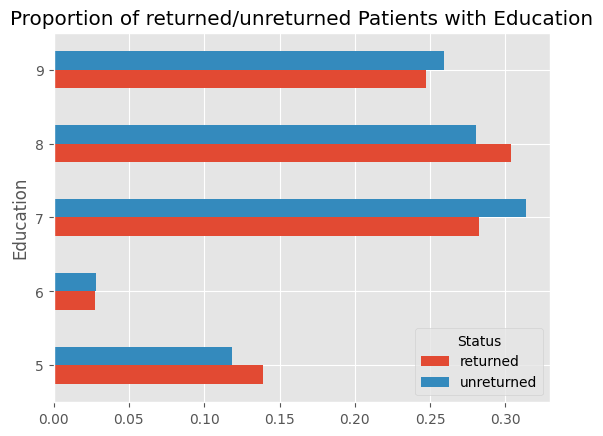

In [9]:
prop_table.plot(kind='barh', title='Proportion of returned/unreturned Patients with Education')
plt.show()

#### calculating total variation distance (TVD) of observed data 
- tvd = sum of abs diff between each proportion, all divided by 2

In [10]:
prop_table = prop_table.assign(abs_diff=abs(prop_table['returned'] - prop_table['unreturned']))
observed_tvd = prop_table['abs_diff'].sum() / 2
print(f'observed tvd: {observed_tvd}')

observed tvd: 0.04406334026725399


## Permutation Test: unreturned/returned patients and education

**Question:** Are the proportional differences between unreturned and returned patients in education statistically significant?

**Null Hypothesis**: The distribution of education amongst unreturned/returned patients come from the same distribution, and any noticeable differences from our sample was due to chance. 

**Alternative Hypothesis** The distribution of education amonst unreturned/returned patients did **not** come from the same distribution, so the differences from our sample was not due to chance. 

### test statistic preparation
we will be calculating total variation distance (TVD)

recall observed TVD: 

In [11]:
observed_tvd

0.04406334026725399

In [12]:
def tvd(shuffled_df): 
    """takes df with status col SHUFFLED, returns tvd"""
    # getting proportion 
    table = shuffled_df.pivot_table(index='Education', columns='Shuffled', aggfunc='size')
    prop_table = table / table.sum()
    
    # adding abs diff col, calculating tvd
    prop_table = prop_table.assign(abs_diff=abs(prop_table['returned'] - prop_table['unreturned']))
    return prop_table['abs_diff'].sum() / 2

### running simulations

**Procedures:**
1. Shuffle `status` column in `df`
2. Compute TVD for new shuffled df 
3. Repeat (1-2) 5000 times, storing each TVD 
4. Calculate P-val + interpret results

In [17]:
simulated_tvds = np.array([])

for i in np.arange(5000):
    #shuffle columns 
    shuffled = df.assign(Shuffled=np.random.permutation(df['Status']))
    #calculate tvd
    new_tvd = tvd(shuffled.get(['Education', 'Shuffled']))
    #append
    simulated_tvds = np.append(simulated_tvds, new_tvd)

simulated_tvds

array([0.02468601, 0.02416707, 0.02622779, ..., 0.00789526, 0.02052943,
       0.03227881])

### visualizing simulated tvds, calculating p-val

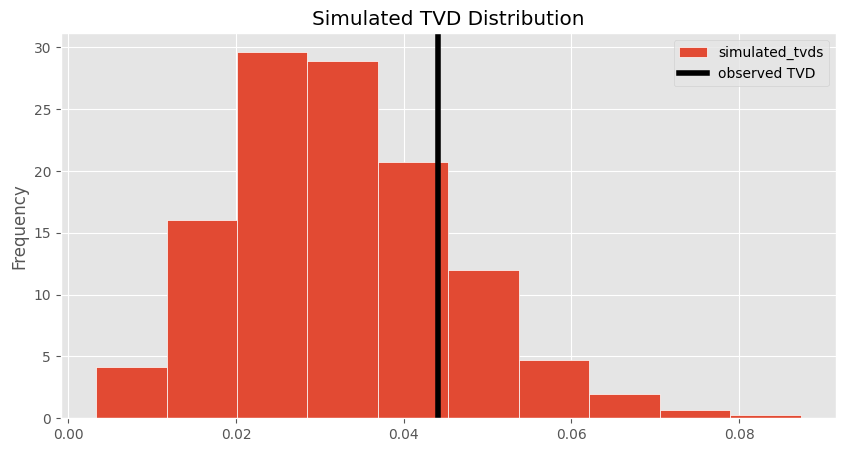

In [18]:
pd.DataFrame().assign(simulated_tvds=simulated_tvds).plot(kind='hist', density=True, ec='w', figsize=(10, 5),\
                                                         title='Simulated TVD Distribution')
plt.axvline(x=observed_tvd, color='black', linewidth=4, label='observed TVD')
plt.legend()
plt.show()

In [15]:
p_val = np.count_nonzero(simulated_tvds >= observed_tvd) / len(simulated_tvds)
p_val

0.1833

#### interpretation/conclusion

Since p-val > 0.1, we have very weak evidence against the null hypothesis. So, we **reject** the null hypothesis, suggesting that is is likely that education amongst unreturned and returned patients came from the same distribution.

# 2. Vitality Status

Is there a statistically significant difference between distribution of vitality status (dead or not dead) amongst returned and unreturned patients?

### exploring observed data

In [34]:
# removing 'unknown' vitality status 
all_vitality = all_patients[all_patients['vitality'] != 2]

# creating DF to observe 
df_vital = pd.DataFrame(all_vitality.get(['id', 'vitality']))
df_vital = df_vital.assign(status=df_vital['id'].apply(get_status))
df_vital = df_vital.get(['vitality', 'status'])
df_vital

,vitality,status
0,1,unreturned
1,1,unreturned
2,1,unreturned
3,1,unreturned
4,1,unreturned
...,...,...
3083,1,returned
3084,1,returned
3085,1,returned
3086,1,unreturned


### plotting observed data

<Figure size 600x800 with 0 Axes>

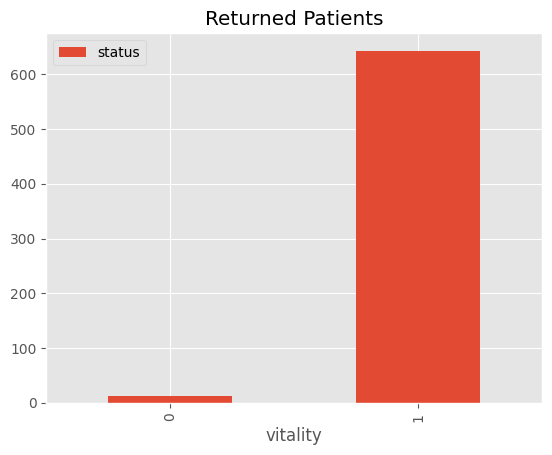

In [60]:
# plotting returned 
plt.figure(figsize=(6,8))
df_vital[df_vital['status'] == 'returned'].groupby('vitality').count().plot(kind='bar', y='status')
plt.title('Returned Patients')
plt.show()

<Figure size 600x800 with 0 Axes>

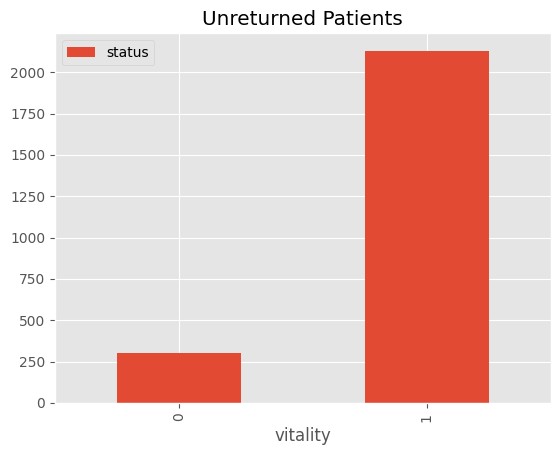

In [61]:
plt.figure(figsize=(6,8))
df_vital[df_vital['status'] == 'unreturned'].groupby('vitality').count().plot(kind='bar', y='status')
plt.title('Unreturned Patients')
plt.show()

In [77]:
vital_returned_count= df_vital[df_vital['status'] == 'returned'].groupby('vitality').count().sort_values('status').reset_index()
returned_dead_prop = vital_returned_count['status'][0] / (df_vital[df_vital['status'] == 'returned'].shape[0])

vital_unreturned_count= df_vital[df_vital['status'] == 'unreturned'].groupby('vitality').count().sort_values('status').reset_index()
unreturned_dead_prop = vital_unreturned_count['status'][0] / (df_vital[df_vital['status'] == 'unreturned'].shape[0])

print('Proportion of Dead Returned: ' + str(returned_dead_prop))
print('Proportion of Dead Unreturned: ' + str(unreturned_dead_prop))

observed_stat = unreturned_dead_prop - returned_dead_prop
print('Difference (unreturned - returned): '+ str(observed_stat)) 

Proportion of Dead Returned: 0.0183206106870229
Proportion of Dead Unreturned: 0.12458881578947369
Difference (unreturned - returned): 0.10626820510245079


In [75]:
# sanity checks --> passed!
# returned_prop = 12/(643+12)
# unreturned_prop = 303/(2129+303)
# print(returned_prop, unreturned_prop)

## Permutation Test: Vitality Status 

**Question:** Are the proportional differences between unreturned and returned patients in vitality status statistically significant?

**Null Hypothesis**: The distribution of dead patients amongst unreturned/returned patients come from the same distribution, and any noticeable differences from our sample was due to chance. 

**Alternative Hypothesis**: There is a higher proportion of patients who died during the study amongst unreturned patients compared to returned patients

### test statistic preparation

In [78]:
observed_stat

0.10626820510245079

In [79]:
df_vital

,vitality,status
0,1,unreturned
1,1,unreturned
2,1,unreturned
3,1,unreturned
4,1,unreturned
...,...,...
3083,1,returned
3084,1,returned
3085,1,returned
3086,1,unreturned


In [102]:
# testing one simulation
# shuffled = df_vital.assign(shuffled=np.random.permutation(df_vital['status'])).get(['vitality', 'shuffled'])
# returned_df = shuffled[shuffled['shuffled'] == 'returned']
# grouped = returned_df.groupby('vitality').count().reset_index().sort_values(by='shuffled')

In [111]:
def prop_diff(shuffled_df):
    """takes shuffled dataset and returned the proportion diff (unreturned-returned)"""
    returned_df = shuffled_df[shuffled_df['shuffled'] == 'returned']
    returned_count = returned_df.groupby('vitality').count().reset_index().sort_values('shuffled').get('shuffled')[0]
    returned_prop = returned_count / (returned_df.shape[0])
    
    unreturned_df = shuffled_df[shuffled_df['shuffled'] == 'unreturned']
    unreturned_count = unreturned_df.groupby('vitality').count().reset_index().sort_values('shuffled').get('shuffled')[0]
    unreturned_prop = unreturned_count / (unreturned_df.shape[0])
    
    return unreturned_prop - returned_prop

### running simulations: procedures

**Procedures:**
1. Shuffle `vitality` column in `df_vital`
2. Compute proportion difference (unreturned-returned) for new shuffled df 
3. Repeat (1-2) 5000 times, storing each difference in array  
4. Calculate P-val + interpret results

In [117]:
simulated_diff = np.array([])

for i in np.arange(5000):
    # create new shuffled df
    shuffled_df = df_vital.assign(shuffled=np.random.permutation(df_vital['status'])).get(['vitality', 'shuffled'])
    # compute test stat
    new_stat = prop_diff(shuffled_df)
    # append to list 
    simulated_diff = np.append(simulated_diff, new_stat)

simulated_diff

array([-0.0119438 , -0.0138817 , -0.03132282, ..., -0.00225429,
        0.01131102,  0.00162151])

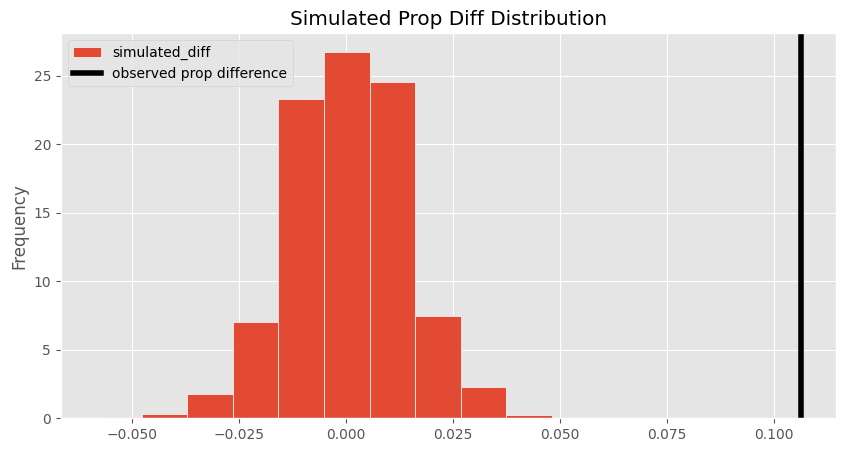

In [118]:
pd.DataFrame().assign(simulated_diff=simulated_diff).plot(kind='hist', density=True, ec='w', figsize=(10, 5),\
                                                         title='Simulated Prop Diff Distribution')
plt.axvline(x=observed_stat, color='black', linewidth=4, label='observed prop difference')
plt.legend()
plt.show()

In [121]:
p_val = np.count_nonzero(simulated_diff >= observed_stat) / len(simulated_tvds)
p_val

0.0

#### interpretation/conclusion

Since p-val >> 0.1, we have very strong evidence to reject the null hypothesis. It is likely that patients being returned and unreturned have a factor in their vitality status, and thus do **not** come from the same distirbution. 